In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict as odict
import time

In [2]:
#Funtion from https://sncosmo.readthedocs.io/en/v2.1.x/api/sncosmo.read_snana_fits.html

def read_snana_fits(head_file, phot_file, snids=None, n=None):

    # Should we memmap? Only if we're going to read only a part of the file
    memmap = (snids is not None or n is not None)

    # Get metadata for all the SNe
    head_data = fits.getdata(head_file, 1, view=np.ndarray)
    phot_data = fits.getdata(phot_file, 1, view=np.ndarray, memmap=memmap)

    # Strip trailing whitespace characters from SNID.
    if 'SNID' in head_data.dtype.names:
        try:
            head_data['SNID'][:] = np.char.strip(head_data['SNID'])
        except TypeError:
            pass

    # Check which indicies to return.
    if snids is None and n is None:
        idx = range(len(head_data))
    elif n is None:
        if 'SNID' not in head_data.dtype.names:
            raise RuntimeError('Specific snids requested, but head file does'
                               ' not contain SNID column')
        idx = []
        for snid in snids:
            i = np.flatnonzero(head_data['SNID'] == snid)
            if len(i) != 1:
                raise RuntimeError('Unique snid requested, but there are '
                                   '{0:d} matching entries'.format(len(i)))
            idx.append(i[0])
    elif snids is None:
        idx = range(n)
    else:
        raise ValueError("cannot specify both 'snids' and 'n' arguments")

    # Loop over SNe in HEAD file
    sne = []
    for i in idx:
        meta = odict(zip(head_data.dtype.names, head_data[i]))

        j0 = head_data['PTROBS_MIN'][i] - 1
        j1 = head_data['PTROBS_MAX'][i]
        data = phot_data[j0:j1]
        if 'FLT' in data.dtype.names:
            data['FLT'][:] = np.char.strip(data['FLT'])
        sne.append(Table(data, meta=meta, copy=False))

    return sne


In [4]:
Path1 = '/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GSN_IDEAL_zALL_p1day'
Path2 = '/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GSN_IDEAL_zALL_36min'

In [6]:
#Count the results but not keeping the data
Path = Path1

PathsDict = {}
FolderNames = os.listdir(Path)
EventNames = []

ObjectNums = []
ObsNums = []
ObsNumStd = []

for FolderName in FolderNames:

  if 'MODEL' in FolderName:
    
    EventName = FolderName[FolderName.find('MODEL')+8:]
    EventNames.append(EventName)

    print('Counting {:<25}'.format(EventName+':'), end='')
    start = time.time()

    SubPath = os.path.join(Path, FolderName)
    FileNames = os.listdir(SubPath)

    ObjectNum = 0
    ObjObsNums = []

    for FileName in FileNames:

      Ind = FileName.find('HEAD')

      if Ind > -1:
        
        print('|', end='')

        FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

        HeadFilePath = os.path.join(SubPath, FileName)
        PhotFilePath = os.path.join(SubPath, FileNamePHOT)        
        SNE = read_snana_fits(HeadFilePath, PhotFilePath)

        objectNum = len(SNE)
        ObjectNum = ObjectNum + objectNum        

        for Obj in range(objectNum):

          ObjObsNums.append(len(SNE[Obj])/6)  

    ObjectNums.append(ObjectNum)
    ObsNums.append(np.mean(ObjObsNums))
    ObsNumStd.append(np.std(ObjObsNums, ddof=1))

    end = time.time()

    print('\t time spent: {0:6.3f} s'.format(end-start))

Counting SNIIn:                   ||||||||||||||||||||	 time spent:  9.401 s
Counting SNIbc-Templates:         ||||||||||||||||||||	 time spent: 11.151 s
Counting uLens-Binary:            ||||||||||||||||||||	 time spent:  9.811 s
Counting SNIa-SALT2:              ||||||||||||||||||||	 time spent: 12.636 s
Counting KN_B19:                  ||||||||||||||||||||	 time spent: 12.909 s
Counting KN_K17:                  ||||||||||||||||||||	 time spent: 13.143 s
Counting RRL:                     ||||||||||||||||||||	 time spent: 13.132 s
Counting AGN:                     ||||||||||||||||||||	 time spent: 12.828 s
Counting uLens-Single_PyLIMA:     ||||||||||||||||||||	 time spent:  8.023 s
Counting SNII-NMF:                ||||||||||||||||||||	 time spent: 13.049 s
Counting SNIax:                   ||||||||||||||||||||	 time spent: 12.522 s
Counting ILOT:                    ||||||||||||||||||||	 time spent:  6.827 s
Counting Mdwarf:                  ||||||||||||||||||||	 time spent: 12.523 s

<Figure size 432x288 with 0 Axes>

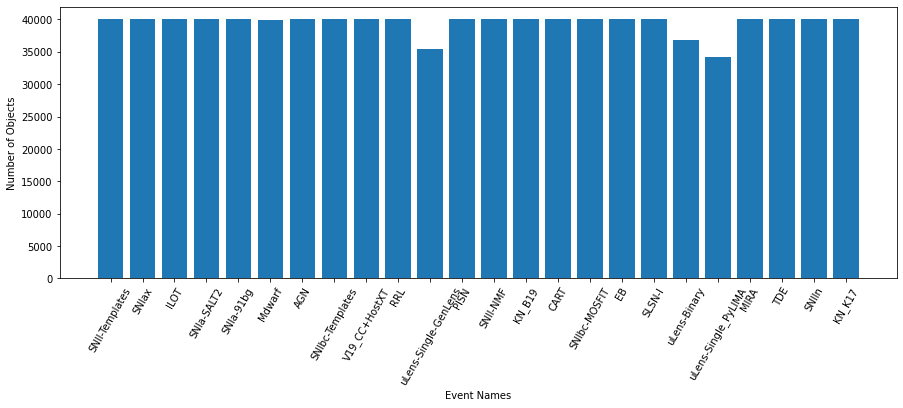

<Figure size 432x288 with 0 Axes>

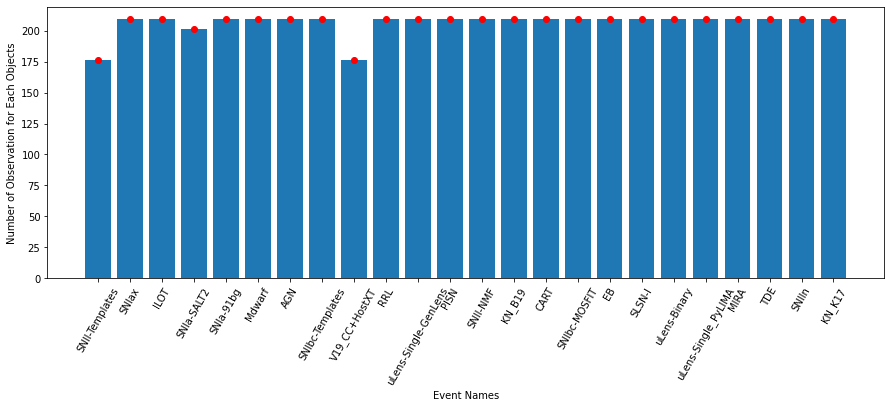

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15,5))

plt.bar(EventNames, ObjectNums)
plt.xticks(rotation = 60) 
plt.xlabel('Event Names')
plt.ylabel('Number of Objects')

plt.figure()

plt.figure(figsize=(15,5))

plt.bar(EventNames, ObsNums)
plt.errorbar(EventNames, ObsNums, ObsNumStd, fmt='o', color = 'r')
plt.xticks(rotation = 60) 
plt.xlabel('Event Names')
plt.ylabel('Number of Observation for Each Objects')

plt.figure()

In [ ]:
#Find out the gaps between observations

Path = '/content/drive/MyDrive/LSST/PLAsTiCC/Data/GSN_IDEAL_z02'

PathsDict = {}
FolderNames = os.listdir(Path)
EventNames = []

GapMean = []
GapStd = []

for FolderName in FolderNames:

  if 'MODEL' in FolderName:
    
    EventName = FolderName[18:]
    EventNames.append(EventName)

    print('Counting {:<25}'.format(EventName+':'), end='')
    start = time.time()

    SubPath = os.path.join(Path, FolderName)
    FileNames = os.listdir(SubPath)

    #Start counting one type of events.

    Gaps = []

    for FileName in FileNames:

      Ind = FileName.find('HEAD')

      if Ind > -1:
        
        print('|', end='')

        FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

        HeadFilePath = os.path.join(SubPath, FileName)
        PhotFilePath = os.path.join(SubPath, FileNamePHOT)        
        SNE = read_snana_fits(HeadFilePath, PhotFilePath)

        for Obj in SNE:

          Bandu = Obj['BAND']=='u '

          Gaps.append(Obj[Bandu]['MJD'][1:] - Obj[Bandu]['MJD'][:-1])

    GapsArray = np.array(Gaps)

    GapMean.append(GapsArray.mean(axis=0))
    GapStd.append(GapsArray.std(axis=0, ddof=1))

    end = time.time()

    print('\t time spent: {0:6.3f} s'.format(end-start))

Counting SNII-Templates:          ||||||||||||||||||||	 time spent: 193.367 s
Counting SNIax:                   ||||||||||||||||||||	 time spent: 201.716 s
Counting ILOT:                    ||||||||||||||||||||	 time spent: 191.727 s
Counting SNIa-SALT2:              ||||||||||||||||||||	 time spent: 192.890 s
Counting SNIa-91bg:               ||||||||||||||||||||	 time spent: 200.282 s
Counting Mdwarf:                  ||||||||||||||||||||	 time spent: 191.337 s
Counting AGN:                     ||||||||||||||||||||	 time spent: 194.595 s
Counting SNIbc-Templates:         ||||||||||||||||||||	 time spent: 200.086 s
Counting V19_CC+HostXT:           ||||||||||||||||||||	 time spent: 188.735 s
Counting RRL:                     ||||||||||||||||||||	 time spent: 200.549 s
Counting uLens-Single-GenLens:    ||||||||||||||||||||	 time spent: 192.202 s
Counting PISN:                    ||||||||||||||||||||	 time spent: 202.474 s
Counting SNII-NMF:                ||||||||||||||||||||	 time spe

Text(0, 0.5, 'Observation gaps (MJD)')

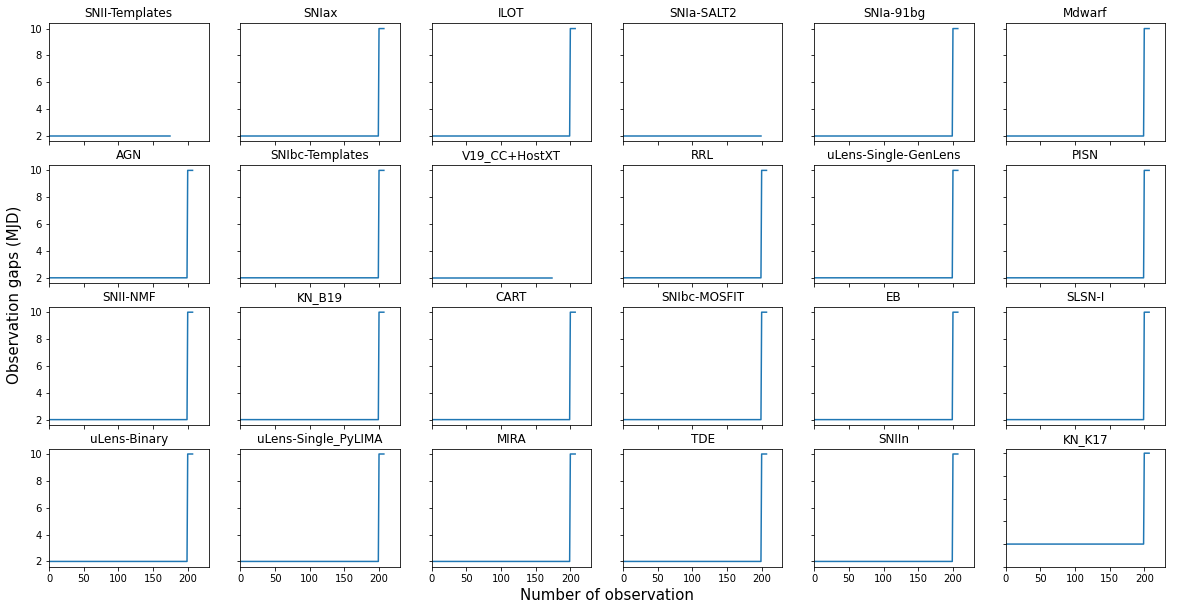

In [ ]:
fig, ax = plt.subplots(4,6, figsize=[20,10], sharex=True, sharey=True)

for I in range(24):

  X = np.arange(len(GapMean[I]))

  ax[I // 6, I % 6].plot(X, GapMean[I])

  ax[I // 6, I % 6].set_title(EventNames[I])
  ax[I // 6, I % 6].set_xlim([0, 230])
  ax[I // 6, I % 6].set_yticks(np.arange(0,12,2))

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.xlabel("Number of observation", fontsize=15)
plt.ylabel("Observation gaps (MJD)", fontsize=15)
  



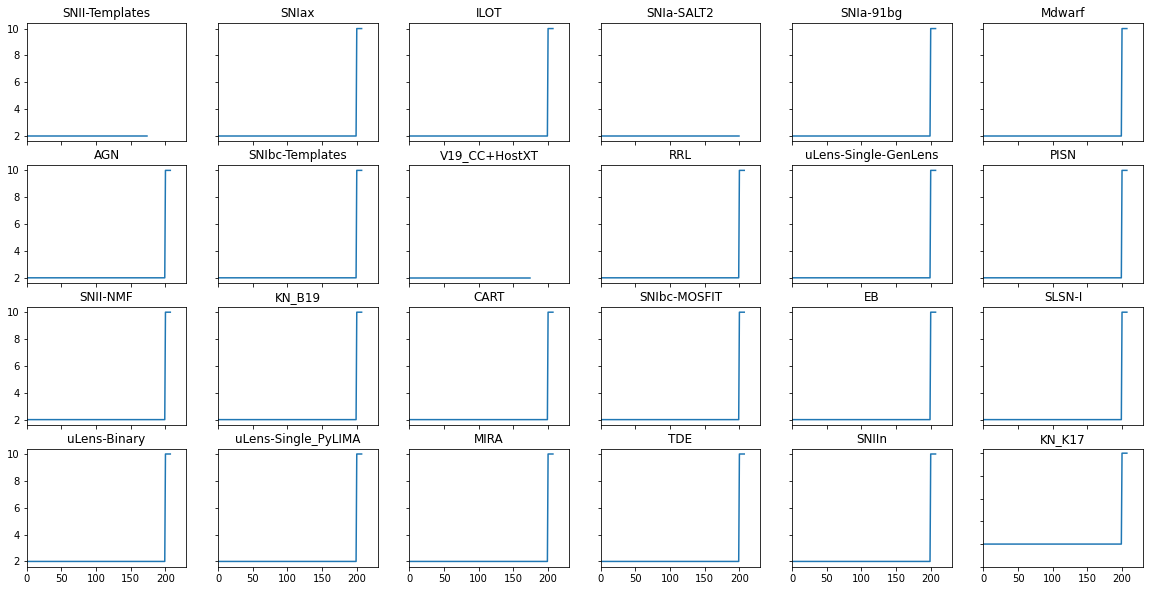

In [ ]:
fig, ax = plt.subplots(4,6, figsize=[20,10], sharex=True, sharey=True)

for I in range(24):

  X = np.arange(len(GapMean[I]))

  ax[I // 6, I % 6].plot(X, GapMean[I])

  ax[I // 6, I % 6].set_title(EventNames[I])
  ax[I // 6, I % 6].set_xlim([0, 230])
  ax[I // 6, I % 6].set_yticks(np.arange(0,12,2))

In [ ]:
GapMean[16]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

In [ ]:
len(GapMean)

24

In [ ]:
aa = SNE[0][SNE[0]['BAND']=='u ']['MJD'][1:] - SNE[0][SNE[0]['BAND']=='u ']['MJD'][:-1]

In [ ]:
type(aa)

astropy.table.column.Column

In [ ]:
aa+1

3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


In [ ]:

AA.append(aa)
AA

[<Column name='MJD' dtype='float64' length=208>
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  ...
  2.0
  2.0
  2.0
  2.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0, <Column name='MJD' dtype='float64' length=208>
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  ...
  2.0
  2.0
  2.0
  2.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0]

In [ ]:
AAarray = np.array(AA)

In [ ]:
AAarray.shape

(2, 208)

In [ ]:
AAarray.std(axis=0, ddof=1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [ ]:
#Read all the data at a time

DataDict = {}
FolderNames = os.listdir(Path)
EventNames = []

ObjectNums = []

for FolderName in FolderNames: 

  if 'MODEL' in FolderName:

    EventName = FolderName[18:]
    EventNames.append(EventName)
    print('Reading ' + EventName)

    SubPath = os.path.join(Path, FolderName)
    FileNames = os.listdir(SubPath)

    Data = []

    for FileName in FileNames:

      Ind = FileName.find('HEAD')

      if Ind > -1:

        FileNamePHOT = FileName[:Ind] + 'PHOT.FITS.gz'

        HeadFilePath = os.path.join(SubPath, FileName)
        PhotFilePath = os.path.join(SubPath, FileNamePHOT)        
        Data.append(read_snana_fits(HeadFilePath, PhotFilePath))

    DataDict[EventName] = Data

Reading SNII-Templates
Reading SNIax
Reading ILOT
